In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


In [3]:
!pip install -q datasets

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 542.0/542.0 kB 10.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 13.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 14.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 401.2/401.2 kB 18.9 MB/s eta 0:00:00


In [4]:
!pip install huggingface_hub
from huggingface_hub import notebook_login

notebook_login()

In [5]:
from datasets import load_dataset, DatasetDict

# Load dataset
ds = load_dataset("Jiwonny29/blueeyes")

# Organize into a single DatasetDict
ds = DatasetDict({
    'train': ds['train'],
    'test': ds['test']
})

Resolving data files:   0%|          | 0/37 [00:00<?, ?it/s]

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

In [6]:
ds['train']

Dataset({
    features: ['image', 'id', 'name', 'type', 'desc', 'atk', 'def', 'level', 'race', 'attribute', 'archetype', 'image_url', 'image_path', 'simplified_type'],
    num_rows: 36
})

In [7]:
ds['test']

Dataset({
    features: ['image', 'id', 'name', 'type', 'desc', 'atk', 'def', 'level', 'race', 'attribute', 'archetype', 'image_url', 'image_path', 'simplified_type'],
    num_rows: 9
})

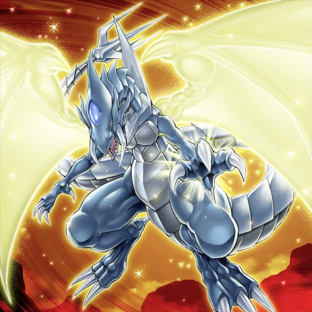

In [8]:
example = ds['train'][0]
image = example["image"]
width, height = image.size
display(image.resize((int(0.5*width), int(0.5*height))))

In [9]:
example["desc"]

'"Blue-Eyes White Dragon" + 1 Dragon monster\r\nMust first be either Fusion Summoned, or Special Summoned from your Extra Deck by Tributing 1 "Blue-Eyes White Dragon" equipped with a Fusion Monster. Unaffected by Trap Cards or effects. This card can attack all monsters your opponent controls, once each. Once per turn, at the end of the Damage Step, if this card battled: You can target 1 Trap in your GY; Set it to your Spell & Trap Zone.'

In [10]:
from torch.utils.data import Dataset

class ImageCaptioningDataset(Dataset):
    def __init__(self, dataset, processor):
        self.dataset = dataset
        self.processor = processor

    def __len__(self):
        return len(self.dataset)

    def __getitem__(self, idx):
        item = self.dataset[idx]

        encoding = self.processor(images=item["image"], text=item["desc"], padding="max_length", return_tensors="pt")

        # remove batch dimension
        encoding = {k:v.squeeze() for k,v in encoding.items()}

        # Generate attention mask
        attention_mask = encoding["input_ids"].clone()
        attention_mask[attention_mask != self.processor.tokenizer.pad_token_id] = 1

        encoding["attention_mask"] = attention_mask

        return encoding

In [11]:
from transformers import AutoProcessor

processor = AutoProcessor.from_pretrained("microsoft/git-base")

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/503 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/453 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/711k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/125 [00:00<?, ?B/s]

In [12]:
train_dataset = ImageCaptioningDataset(ds['train'], processor)

In [13]:
item = train_dataset[0]
for k,v in item.items():
  print(k,v.shape)

Unused or unrecognized kwargs: padding.


input_ids torch.Size([512])
attention_mask torch.Size([512])
pixel_values torch.Size([3, 224, 224])


In [14]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_dataset, shuffle=True, batch_size=2)

In [15]:
batch = next(iter(train_dataloader))
for k,v in batch.items():
  print(k,v.shape)

Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


input_ids torch.Size([2, 512])
attention_mask torch.Size([2, 512])
pixel_values torch.Size([2, 3, 224, 224])


In [16]:
processor.decode(batch["input_ids"][0])

'[CLS] reveal 3 cards from your deck that each meets at least 1 of the criteria listed below, your opponent randomly picks 1 for you to add to your hand, and you shuffle the rest into your deck. you can only activate 1 " bingo machine, go!!! " per turn. ● " blue - eyes " monster ● spell / trap that specifically lists the card " blue - eyes white dragon " or " blue - eyes ultimate dragon ", except " bingo machine, go!!! " [SEP] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD] [PAD]

In [ ]:
import numpy as np
from PIL import Image

# Load an image. For example, specify the image file path in 'image_path'.
image = Image.open('/content/drive/MyDrive/71039903.jpg')

# Convert the image to a numpy array.
image_array = np.array(image)

# Calculate the mean and standard deviation for each channel of the image.
mean = np.mean(image_array, axis=(0, 1))
std = np.std(image_array, axis=(0, 1))

print("Mean:", mean)
print("Std:", std)

Mean: [131.65546926 146.45824088 114.93689647]
Std: [76.93995866 72.13034857 89.25502009]


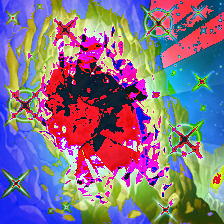

In [ ]:
from PIL import Image
import numpy as np

MEAN = np.array([131.65546926, 146.45824088, 114.93689647]) / 255
STD = np.array([76.93995866, 72.13034857, 89.25502009]) / 255

unnormalized_image = (batch["pixel_values"][0].numpy() * np.array(STD)[:, None, None]) + np.array(MEAN)[:, None, None]
unnormalized_image = (unnormalized_image * 255).astype(np.uint8)
unnormalized_image = np.moveaxis(unnormalized_image, 0, -1)
Image.fromarray(unnormalized_image)

In [17]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained("microsoft/git-base")

config.json:   0%|          | 0.00/2.82k [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/707M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/141 [00:00<?, ?B/s]

In [18]:
outputs = model(input_ids=batch["input_ids"],
                attention_mask=batch["attention_mask"],
                pixel_values=batch["pixel_values"],
                labels=batch["input_ids"])
outputs.loss

tensor(11.2370, grad_fn=<NllLossBackward0>)

In [19]:
import torch

optimizer = torch.optim.AdamW(model.parameters(), lr=5e-5)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)

model.train()

for epoch in range(50):
  print("Epoch:", epoch)
  for idx, batch in enumerate(train_dataloader):
    input_ids = batch.pop("input_ids").to(device)
    pixel_values = batch.pop("pixel_values").to(device)

    outputs = model(input_ids=input_ids,
                    pixel_values=pixel_values,
                    labels=input_ids)

    loss = outputs.loss

    print("Loss:", loss.item())

    loss.backward()

    optimizer.step()
    optimizer.zero_grad()

Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
We strongly recommend passing in an `attention_mask` since your input_ids may be padded. See https://huggingface.co/docs/transformers/troubleshooting#incorrect-output-when-padding-tokens-arent-masked.


Epoch: 0
Loss: 11.003522872924805


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 10.222309112548828


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 9.88046932220459


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 9.50588607788086


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 9.810498237609863


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 9.480304718017578


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 8.975085258483887


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 8.888165473937988


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 8.693977355957031


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 8.532635688781738


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 8.220596313476562


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 8.149127006530762


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 7.819189548492432


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 7.940610885620117


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 8.140298843383789


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 7.722238540649414


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 7.816971302032471


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 7.471923351287842
Epoch: 1


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 7.1940531730651855


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 7.3639140129089355


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 6.934879779815674


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 6.781725883483887


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 6.6913065910339355


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 6.567338466644287


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 6.64499044418335


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 6.770567893981934


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 6.679499626159668


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 6.530007839202881


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 6.674288749694824


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 6.199374198913574


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 6.338676929473877


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 6.053807258605957


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 6.031506061553955


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 5.882537841796875


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 5.784440040588379


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 5.6601409912109375
Epoch: 2


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 5.422867298126221


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 5.437387466430664


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 5.428926467895508


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 5.221566677093506


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 5.273229598999023


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 5.152990341186523


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 5.1744794845581055


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 4.737033367156982


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 4.96239709854126


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 4.854288101196289


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 4.589293479919434


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 4.512650966644287


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 4.2223405838012695


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 4.3127121925354


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 4.143665313720703


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 3.9622304439544678


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 4.02028226852417


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 4.061972141265869
Epoch: 3


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 3.773405075073242


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 3.852616310119629


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 3.5776748657226562


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 3.357102394104004


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 3.4887804985046387


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 3.3670473098754883


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 3.2417681217193604


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 3.1023190021514893


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 3.128382682800293


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 2.967796802520752


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 2.7815308570861816


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 2.787059783935547


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 2.569509983062744


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 2.723641872406006


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 2.4527015686035156


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 2.4943628311157227


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 2.3230836391448975


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 2.2036550045013428
Epoch: 4


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 2.1576695442199707


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 2.0645062923431396


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 2.0426268577575684


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 1.8729602098464966


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 1.6848931312561035


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 1.8769710063934326


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 1.553831934928894


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 1.5290628671646118


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 1.4908479452133179


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 1.3995591402053833


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 1.3144598007202148


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 1.190349817276001


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 1.5060299634933472


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 1.2423287630081177


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 1.120461344718933


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 1.0849967002868652


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 1.0638211965560913


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 1.0034174919128418
Epoch: 5


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 1.1064094305038452


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.8427384495735168


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.6965504884719849


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.941896378993988


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.7873970866203308


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.7852345108985901


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.82148677110672


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.7722820043563843


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.635809063911438


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.6026105284690857


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.4621160924434662


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.6134056448936462


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.7044066786766052


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.6757531762123108


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.5454404354095459


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.6537267565727234


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.4249148368835449


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.5323134064674377
Epoch: 6


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.4925489127635956


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.44757935404777527


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.5576367378234863


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.33446258306503296


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.3238098621368408


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.42612460255622864


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.41214942932128906


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.40635934472084045


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.3331336975097656


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.3354194760322571


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.5918810367584229


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.6409075260162354


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.3768879771232605


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.28762778639793396


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.460206001996994


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.35553863644599915


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.4062950015068054


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.4648500978946686
Epoch: 7


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.3021959960460663


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.27583080530166626


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.3322596848011017


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.39690420031547546


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.17549392580986023


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.3082839846611023


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.46317407488822937


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.18144045770168304


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.32027536630630493


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.3156886696815491


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.26815810799598694


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.3722437024116516


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.41590264439582825


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.384563684463501


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.3540246784687042


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.22020532190799713


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2737288773059845


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.29330530762672424
Epoch: 8


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.31666770577430725


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.23638156056404114


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.14130176603794098


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2074248492717743


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2708187997341156


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.34868893027305603


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.30381664633750916


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.3361779749393463


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.28806939721107483


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2697823643684387


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.14541369676589966


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.3047901690006256


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.17566657066345215


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.36134102940559387


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.15104682743549347


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.27485617995262146


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.19608759880065918


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2282569259405136
Epoch: 9


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.25217312574386597


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.31096985936164856


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.22146736085414886


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.16153265535831451


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.27099332213401794


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.17924830317497253


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.24942848086357117


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.32247394323349


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.10333985835313797


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2296951711177826


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.15964765846729279


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.25035324692726135


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.13955344259738922


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1439407765865326


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.17416472733020782


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2185063660144806


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2731339633464813


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.12948709726333618
Epoch: 10


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.09086146950721741


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1557963341474533


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.18967440724372864


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1958572119474411


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.19107329845428467


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.26669448614120483


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.179189994931221


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.23183561861515045


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.12789174914360046


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05602210760116577


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.11490003019571304


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1772613674402237


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.22956492006778717


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2621975541114807


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.23294618725776672


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.15771141648292542


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.10467072576284409


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.18150904774665833
Epoch: 11


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.12375886738300323


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.15309596061706543


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.20148074626922607


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.21092188358306885


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08779013901948929


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.12642978131771088


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.15560172498226166


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1862628161907196


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.09289276599884033


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.12589871883392334


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.16791924834251404


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.20196425914764404


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.11557366698980331


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07017654925584793


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.17734773457050323


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.19314686954021454


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.15166465938091278


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.15300199389457703
Epoch: 12


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.09591128677129745


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.14423151314258575


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.18450145423412323


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.17495471239089966


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.12860022485256195


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.20479492843151093


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.2086082547903061


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08815603703260422


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.12675543129444122


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07475567609071732


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.14858917891979218


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.10217469930648804


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1123650074005127


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.10996610671281815


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.10159032046794891


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.10963501036167145


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1467611938714981


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.09053736925125122
Epoch: 13


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.11231758445501328


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.18251003324985504


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.15107689797878265


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.11967889219522476


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.10703694820404053


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07036693394184113


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.09010079503059387


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.10324344784021378


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08326341211795807


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0860380083322525


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.12054367363452911


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.09259529411792755


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08709146827459335


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.12677448987960815


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.14044564962387085


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.14512453973293304


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.059871040284633636


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.10197935253381729
Epoch: 14


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1405395269393921


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08401072770357132


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.11805108189582825


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.11624465137720108


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07360653579235077


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05389374867081642


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.13699327409267426


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0999031737446785


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0562676303088665


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.09048118442296982


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05808573588728905


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.11585000902414322


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.061637818813323975


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.10493571311235428


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03700198233127594


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1290808767080307


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.12298405915498734


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.14229200780391693
Epoch: 15


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08529727160930634


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.09425820410251617


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.11903500556945801


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03139983490109444


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.11507503688335419


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.10410279780626297


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05252177640795708


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06650978326797485


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.10660050064325333


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05463355779647827


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.11383188515901566


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.042975831776857376


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07156404107809067


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0709412693977356


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.10159973800182343


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06723888218402863


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.15127576887607574


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07289224117994308
Epoch: 16


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08672010898590088


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07321091741323471


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.061942096799612045


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08774865418672562


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04741920158267021


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07381518185138702


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.11437740176916122


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07205318659543991


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07644141465425491


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08440382033586502


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.077444888651371


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03239304572343826


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07519664615392685


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08258640021085739


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0581771619617939


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0506923608481884


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.09870901703834534


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.10416676849126816
Epoch: 17


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.12205233424901962


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06532794237136841


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06908024102449417


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04412544146180153


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05191502347588539


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0948326364159584


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04107766970992088


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025141799822449684


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08250553160905838


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02345120720565319


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0641094371676445


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07545073330402374


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05781015381217003


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06756506860256195


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.058018460869789124


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0749332383275032


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07329919934272766


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08762825280427933
Epoch: 18


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06900959461927414


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06753519177436829


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.046732347458601


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06124813109636307


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0726282149553299


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.035958144813776016


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.061771929264068604


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.029970835894346237


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.039502739906311035


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.051140159368515015


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04655325785279274


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07280600070953369


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05130564048886299


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.061383530497550964


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.047588057816028595


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.1009550616145134


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03584197908639908


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.08785877376794815
Epoch: 19


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07649154216051102


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07220849394798279


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06195652857422829


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02618628740310669


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07105150073766708


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05604742467403412


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.044332899153232574


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03406086564064026


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04533231630921364


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02398666739463806


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03682411089539528


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.030852722004055977


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07028204202651978


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.055965229868888855


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07803598791360855


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07333265244960785


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0509856641292572


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0321824885904789
Epoch: 20


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018531089648604393


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04116290435194969


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04319782555103302


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.028167633339762688


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03955481946468353


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0387091189622879


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.055739231407642365


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07038280367851257


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05549173057079315


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07350794970989227


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03935806453227997


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.041314564645290375


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.043425433337688446


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06507717072963715


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06277099996805191


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04253172501921654


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05615512654185295


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.058678705245256424
Epoch: 21


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.028286680579185486


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04006139189004898


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05209675058722496


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0530700609087944


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03487066924571991


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.07542398571968079


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03856445103883743


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03416048362851143


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.045531753450632095


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03324185311794281


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06511203199625015


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.038720905780792236


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05429898947477341


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06863438338041306


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.026809845119714737


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05382716283202171


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.028497621417045593


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04565940424799919
Epoch: 22


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03812235966324806


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05281973257660866


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.050535593181848526


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02160189114511013


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0292751956731081


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0625724121928215


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.049994077533483505


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04091491177678108


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05665988847613335


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025890672579407692


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05341189727187157


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02696160040795803


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025414006784558296


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03986821696162224


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05441654473543167


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05041680485010147


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.037901341915130615


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0350942425429821
Epoch: 23


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023216160014271736


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02935849502682686


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.033382169902324677


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.028039997443556786


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06844361126422882


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025903694331645966


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025516949594020844


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04347747564315796


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04795344918966293


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.057901494204998016


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.043970704078674316


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.028068091720342636


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05299556627869606


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04305992275476456


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.051910508424043655


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015383650548756123


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0458422526717186


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03703169524669647
Epoch: 24


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.043229859322309494


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019302884116768837


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04035680368542671


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015079854987561703


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.06799408048391342


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05485422536730766


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02708294242620468


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03231188282370567


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02878599800169468


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020177451893687248


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.030819645151495934


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03874141350388527


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.039929937571287155


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03318266570568085


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04468776658177376


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05098363384604454


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.05651730298995972


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03168792650103569
Epoch: 25


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0225096195936203


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020589273422956467


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.041798580437898636


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.031234225258231163


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04113643243908882


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03328125551342964


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02968076802790165


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04350533336400986


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.030103472992777824


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03136889263987541


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03240690752863884


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03987161070108414


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03778345137834549


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.056165385991334915


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02901838719844818


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01985343173146248


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.039797864854335785


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03327016904950142
Epoch: 26


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02809874527156353


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03765610232949257


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04083847999572754


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03604217618703842


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04906865954399109


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.029778990894556046


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.028994698077440262


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02992887981235981


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03289513289928436


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01483606081455946


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02830289676785469


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02914705127477646


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02918349765241146


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03671777993440628


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017515303567051888


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04560429975390434


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01811089925467968


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03375038132071495
Epoch: 27


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.031998567283153534


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02569148689508438


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0398520864546299


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04630081355571747


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03206411376595497


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.035713039338588715


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020472727715969086


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0292633306235075


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0379912406206131


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024207012727856636


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.029810752719640732


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02921009063720703


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01664978824555874


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.039939720183610916


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03371359780430794


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0273726899176836


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0262643713504076


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014618994668126106
Epoch: 28


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02794690802693367


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021470272913575172


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.027221795171499252


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.029613908380270004


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.028499362990260124


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022394023835659027


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025828614830970764


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.030031269416213036


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.026264866814017296


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0340954065322876


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.030550049617886543


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.026911906898021698


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024219147861003876


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.046567756682634354


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.027545306831598282


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022388821467757225


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03177182748913765


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01570354588329792
Epoch: 29


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03603760153055191


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02791617065668106


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019819248467683792


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.030181868001818657


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02048340253531933


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.029131336137652397


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020235273987054825


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024887507781386375


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04039670526981354


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025137832388281822


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03629842773079872


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02824634686112404


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.026929542422294617


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02009470760822296


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02624240145087242


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.030038194730877876


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01725177653133869


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01086343452334404
Epoch: 30


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019000474363565445


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04131804406642914


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.030483147129416466


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.027372144162654877


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025698784738779068


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023212848231196404


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01889580674469471


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023855827748775482


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020535776391625404


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03328786417841911


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016244564205408096


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.035633187741041183


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02245822362601757


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018244527280330658


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025016792118549347


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023531101644039154


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.04061633348464966


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020675668492913246
Epoch: 31


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.028560951352119446


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021345308050513268


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.030735855922102928


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023994240909814835


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.030099989846348763


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01854267343878746


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02981332689523697


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.034641142934560776


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03020300716161728


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020314084365963936


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022030949592590332


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.039145756512880325


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01137686986476183


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015596301294863224


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020858578383922577


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013535713776946068


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.026991305872797966


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01740911230444908
Epoch: 32


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019073259085416794


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02243136055767536


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02926940843462944


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.028141237795352936


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020403292030096054


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01648477464914322


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.029363088309764862


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02700117602944374


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03310726210474968


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016848744824528694


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018702687695622444


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023915758356451988


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025917701423168182


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019234223291277885


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019812561571598053


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03733735531568527


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024296553805470467


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01776028797030449
Epoch: 33


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02484850212931633


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021803561598062515


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017865752801299095


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02616281993687153


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016068026423454285


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02701943926513195


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025462210178375244


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019534310325980186


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018249407410621643


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010434598661959171


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023456169292330742


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02819645032286644


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.028667179867625237


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01728002354502678


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022451650351285934


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01806160807609558


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025780443102121353


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02134215645492077
Epoch: 34


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009212996810674667


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.03356350213289261


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02871282771229744


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020774325355887413


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02436881884932518


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.028898252174258232


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020522449165582657


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02602287009358406


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019032733514904976


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01776520535349846


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023479361087083817


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022634264081716537


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01905297487974167


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01828935369849205


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019628142938017845


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017667677253484726


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.030868861824274063


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023282518610358238
Epoch: 35


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01630268804728985


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013246378861367702


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024941865354776382


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016748851165175438


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018113741651177406


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02582097239792347


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.029695574194192886


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.031183436512947083


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018292129039764404


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0185930784791708


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02045593038201332


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01791372336447239


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010071047581732273


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.030193470418453217


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0229481253772974


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015491429716348648


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021851712837815285


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02623915672302246
Epoch: 36


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008201681077480316


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022356724366545677


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.028227439150214195


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020534740760922432


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021192725747823715


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.028553731739521027


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0202066358178854


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.026252886280417442


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0309592392295599


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022216662764549255


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02340324968099594


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013267708010971546


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020714787766337395


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014326127246022224


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019536586478352547


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019594205543398857


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01869852840900421


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02330581098794937
Epoch: 37


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016923485323786736


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02569548226892948


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011654356494545937


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025726089254021645


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02143823355436325


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01943548396229744


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010711539536714554


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024925701320171356


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01708287186920643


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.030845724046230316


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.028694521635770798


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02226094901561737


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013123052194714546


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.027237648144364357


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.030004650354385376


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015531077980995178


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016424281522631645


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017721042037010193
Epoch: 38


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011760118417441845


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024330729618668556


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008448234759271145


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015436583198606968


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018291573971509933


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016745727509260178


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014358382672071457


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.025443777441978455


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024495504796504974


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014256107620894909


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02216929942369461


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02220965176820755


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019798921421170235


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020217889919877052


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018854226917028427


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021816134452819824


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02185834012925625


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02492760680615902
Epoch: 39


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019171858206391335


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01163502037525177


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018833940848708153


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016103172674775124


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01196446642279625


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012577218003571033


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020448075607419014


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013530994765460491


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023495066910982132


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0198400616645813


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015522019937634468


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020627617835998535


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01690038852393627


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02182144857943058


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01644238829612732


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023831745609641075


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014472139067947865


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016200480982661247
Epoch: 40


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019763490185141563


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012684411369264126


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019220035523176193


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02007123827934265


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011158681474626064


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016156217083334923


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01635553501546383


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016300832852721214


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012284008786082268


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018997762352228165


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01982678845524788


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020310208201408386


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022106042131781578


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011448005214333534


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.028220338746905327


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021019382402300835


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015170480124652386


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017184851691126823
Epoch: 41


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01669836975634098


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0197097547352314


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018293019384145737


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01670013926923275


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021012144163250923


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015078222379088402


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011819490231573582


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017564496025443077


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017875581979751587


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01964811608195305


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.007390810642391443


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015899736434221268


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017741438001394272


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01670866273343563


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.021792033687233925


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022513113915920258


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017004767432808876


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015549992211163044
Epoch: 42


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019526761025190353


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013220921158790588


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018396293744444847


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016111018136143684


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012650233693420887


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017469145357608795


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018569163978099823


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017740141600370407


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.023554714396595955


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013589237816631794


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018633922562003136


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014426371082663536


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013508197851479053


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0184211153537035


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018348263576626778


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01113769132643938


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008372997865080833


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015149385668337345
Epoch: 43


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0063728285022079945


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012462247163057327


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014797341078519821


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.00962270051240921


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017558693885803223


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018328875303268433


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012382359243929386


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01418422069400549


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016756005585193634


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.024265022948384285


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01734922267496586


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018379300832748413


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015378395095467567


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016325894743204117


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016019925475120544


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0184274110943079


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016482623293995857


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015319615602493286
Epoch: 44


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015796301886439323


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013798057101666927


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014502361416816711


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01462993212044239


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016116071492433548


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014887218363583088


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014144261367619038


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015633003786206245


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010810320265591145


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01444146316498518


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015760118141770363


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01092956867069006


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01438040379434824


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018357714638113976


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017239131033420563


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017924951389431953


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020291931927204132


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01800585724413395
Epoch: 45


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013866506516933441


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016718510538339615


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013539961539208889


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008503383956849575


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012776856310665607


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013701658695936203


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015719952061772346


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012364605441689491


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016157038509845734


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020377526059746742


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014260935597121716


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016865210607647896


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018114620819687843


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.018792234361171722


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01461871899664402


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01670224405825138


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010670228861272335


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011770755983889103
Epoch: 46


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014340979047119617


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01597965508699417


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010901257395744324


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01275266706943512


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016351427882909775


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014196932315826416


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019221145659685135


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016615819185972214


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.02120606042444706


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01217582356184721


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011714978143572807


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011315243318676949


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010559851303696632


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.022435832768678665


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016045834869146347


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010202890262007713


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.00888690073043108


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0194412674754858
Epoch: 47


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013348396867513657


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013996269553899765


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.008700973354279995


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014420895837247372


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01107688806951046


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016424400731921196


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015108254738152027


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020065853372216225


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01976117677986622


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01586906425654888


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015989111736416817


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.009235221892595291


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011590912006795406


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015582564286887646


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.020067179575562477


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010220004245638847


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013996659778058529


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014762721955776215
Epoch: 48


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01471710205078125


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.017014874145388603


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.00974042434245348


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019800255075097084


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012061973102390766


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01336228009313345


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01741119474172592


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015442593023180962


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015739230439066887


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014643116854131222


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013012412004172802


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013614865019917488


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01482622791081667


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.019281625747680664


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015382932499051094


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011523050256073475


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.014957091771066189


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01563289202749729
Epoch: 49


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013168452307581902


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013836749829351902


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.016676612198352814


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.010687950067222118


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0101637477055192


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.015138313174247742


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01536231953650713


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01281360536813736


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01264437660574913


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.012738699093461037


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011813065968453884


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.011009822599589825


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.01974639482796192


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.004922950640320778


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.004723383579403162


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.0190752986818552


Unused or unrecognized kwargs: padding.
Unused or unrecognized kwargs: padding.


Loss: 0.013934687711298466
Loss: 0.022052716463804245


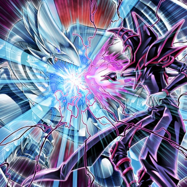

In [20]:
# load image
example = ds['test'][0]
image = example["image"]
width, height = image.size
display(image.resize((int(0.3*width), int(0.3*height))))

In [21]:
# prepare image for the model
inputs = processor(images=image, return_tensors="pt").to(device)
pixel_values = inputs.pixel_values

generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]
print(generated_caption)

this legendary dragon is a powerful engine of destruction. virtually invincible, very few have faced this awesome creature and lived to tell the tale.


### Ground Truth Text
66961194.jpg

While you control a "Blue-Eyes" monster, you choose the attack targets for your opponent's attacks. You can only use each of the following effects of "Dictator of D." once per turn. You can send 1 "Blue-Eyes White Dragon" from your hand or Deck to the GY; Special Summon this card from your hand. You can discard 1 "Blue-Eyes White Dragon", or 1 card that mentions it, then target 1 "Blue-Eyes" monster in your GY; Special Summon it.

In [22]:
from nltk.translate.bleu_score import corpus_bleu
import nltk
nltk.download('punkt')

# Prepare test data
test_dataset = ImageCaptioningDataset(ds['test'], processor)

# DataLoader for test data
test_dataloader = DataLoader(test_dataset, shuffle=False, batch_size=1)

# Generate captions for test data
generated_captions = []
ground_truth_captions = []

model.eval()
with torch.no_grad():
    for example in ds['test']:
        image = example["image"]
        inputs = processor(images=image, return_tensors="pt").to(device)
        pixel_values = inputs.pixel_values

        generated_ids = model.generate(pixel_values=pixel_values, max_length=50)
        generated_caption = processor.batch_decode(generated_ids, skip_special_tokens=True)[0]

        generated_captions.append(generated_caption)
        ground_truth_captions.append(example["desc"])

# Calculate BLEU score
bleu_score = corpus_bleu([[caption] for caption in ground_truth_captions], generated_captions)

print("BLEU Score:", bleu_score)

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.


BLEU Score: 0.16222567275892225


In [23]:
model.save_pretrained("/content/drive/MyDrive")